# Differential Evolution

In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)

Using device cuda


In [2]:
from collections.abc import Callable
from tqdm.auto import tqdm


def differential_evolution(
        problem: Callable[[torch.Tensor], torch.Tensor],
        n_population: int = 20,
        F: float = 0.5,
        CR: float = 0.7,
        dim: int = 10,
        search_boundary: tuple = (-5, 5),
        n_generations: int = 100,
        maximize: bool = False) -> dict:
    """Simple Differential Evolution (DE) implementation."""

    lower, upper = search_boundary

    # Randomly initialize population
    population = torch.rand((n_population, dim), device=device) * (upper - lower) + lower
    fitness = problem(population)

    best_fitness_history = []
    mean_fitness_history = []

    # Optimization loop
    for _ in (pbar := tqdm(range(n_generations), desc="DE Progress")):
        # Pick three *distinct* indices not equal itself. We do this for all individuals in parallel.
        idxs = torch.arange(n_population, device=device).unsqueeze(0).repeat(n_population, 1)
        mask = torch.eye(n_population, dtype=torch.bool, device=device)
        idxs = idxs[~mask].view(n_population, n_population - 1)

        permutation = torch.stack([torch.randperm(n_population - 1, device=device)[:3] for _ in range(n_population)])
        r = idxs.gather(1, permutation)
        assert r.shape[1] >= 3
        candidates = population[r]  # Shape: (n_population, 3, dim)

        # Mutation
        mutants = candidates[:, 0] + F * (candidates[:, 1] - candidates[:, 2])
        mutants = torch.clamp(mutants, lower, upper)

        # Crossover (binomial)
        cross_points = torch.rand((n_population, dim), device=device) < CR
        j_rand = torch.randint(0, dim, (n_population,), device=device).unsqueeze(1)
        cross_points.scatter_(1, j_rand, True)
        trials = torch.where(cross_points, mutants, population)

        # Selection
        f_trials = problem(trials)
        if maximize:
            better_mask = f_trials > fitness
        else:
            better_mask = f_trials < fitness

        population = torch.where(better_mask.unsqueeze(1), trials, population)
        fitness = torch.where(better_mask, f_trials, fitness)

        # Record best and mean fitness
        best_idx = torch.argmin(fitness) if not maximize else torch.argmax(fitness)
        best_fitness_history.append(fitness[best_idx].item())
        mean_fitness_history.append(fitness.mean().item())

        # Update progress bar
        pbar.set_postfix({"best_fitness": best_fitness_history[-1], "mean_fitness": mean_fitness_history[-1]})

    return {
        "best_solution": population[best_idx],
        "best_fitness": fitness[best_idx],
        "fitness_history": {
            "best": best_fitness_history,
            "mean": mean_fitness_history
        }
    }

In [5]:
from objective_functions import sphere, rastrigin, rosenbrock, ackley, schwefel, griewank, levy


objective_functions = {
    "sphere": {
        "function": sphere,
        "search_boundary": (-5, 5),
        "solution": None
    },
    "rastrigin": {
        "function": rastrigin,
        "search_boundary": (-5.12, 5.12),
        "solution": None
    },
    "rosenbrock": {
        "function": rosenbrock,
        "search_boundary": (-2, 2),
        "solution": None
    },
    "ackley": {
        "function": ackley,
        "search_boundary": (-10, 10),
        "solution": None
    },
    "schwefel": {
        "function": schwefel,
        "search_boundary": (-500, 500),
        "solution": None
    },
    "griewank": {
        "function": griewank,
        "search_boundary": (-100, 100),
        "solution": None
    },
    "levy": {
        "function": levy,
        "search_boundary": (-10, 10),
        "solution": None
    }
}

for name, obj in objective_functions.items():
    obj["solution"] = differential_evolution(
        problem=obj["function"],
        dim=10,
        search_boundary=obj["search_boundary"],
        n_generations=5000,
        n_population=100,
        F=0.5,
        CR=0.7,
        maximize=False
    )

DE Progress:   0%|          | 0/5000 [00:00<?, ?it/s]

DE Progress:   0%|          | 0/5000 [00:00<?, ?it/s]

DE Progress:   0%|          | 0/5000 [00:00<?, ?it/s]

DE Progress:   0%|          | 0/5000 [00:00<?, ?it/s]

DE Progress:   0%|          | 0/5000 [00:00<?, ?it/s]

DE Progress:   0%|          | 0/5000 [00:00<?, ?it/s]

DE Progress:   0%|          | 0/5000 [00:00<?, ?it/s]

=== SPHERE FUNCTION ===
Best solution found: tensor([ 1.3463e-23,  2.5505e-23, -1.3502e-23,  3.9091e-24,  1.4753e-23,
         4.0425e-24,  3.2687e-25,  1.5100e-23,  8.1017e-25, -6.2063e-25],
       device='cuda:0')
Best solution fitness: tensor(0., device='cuda:0')



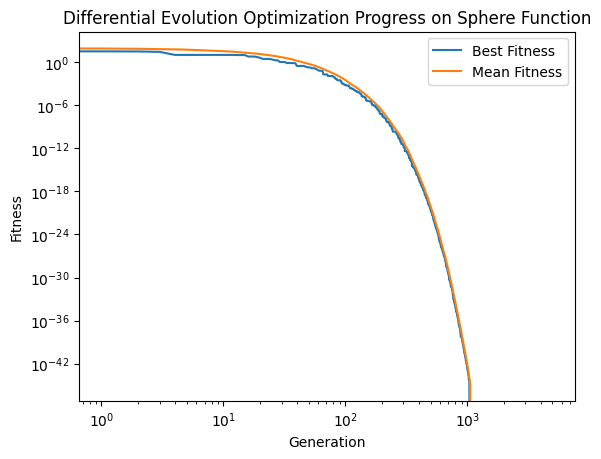

=== RASTRIGIN FUNCTION ===
Best solution found: tensor([ 8.5828e-05, -5.4562e-05, -1.0893e-04,  3.6661e-05, -1.9761e-05,
        -5.7455e-05,  7.1825e-05, -4.6722e-05,  1.0611e-05, -1.5584e-05],
       device='cuda:0')
Best solution fitness: tensor(0., device='cuda:0')



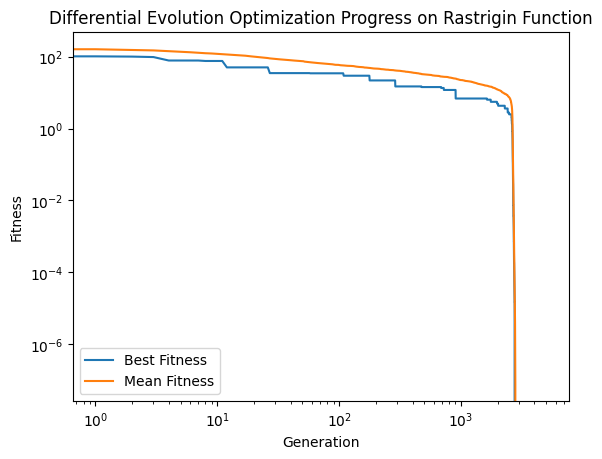

=== ROSENBROCK FUNCTION ===
Best solution found: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
Best solution fitness: tensor(0., device='cuda:0')



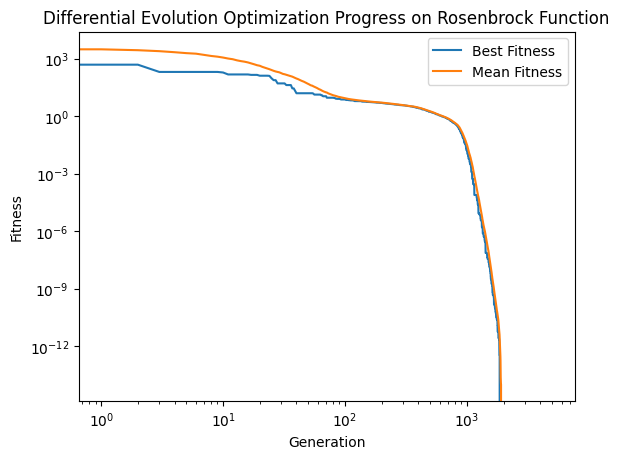

=== ACKLEY FUNCTION ===
Best solution found: tensor([ 2.0848e-07, -5.8522e-07,  9.1128e-08,  9.3086e-07, -9.5467e-08,
         5.4815e-07,  2.1282e-06,  4.6152e-07, -4.8285e-07, -1.7644e-07],
       device='cuda:0')
Best solution fitness: tensor(9.5367e-07, device='cuda:0')



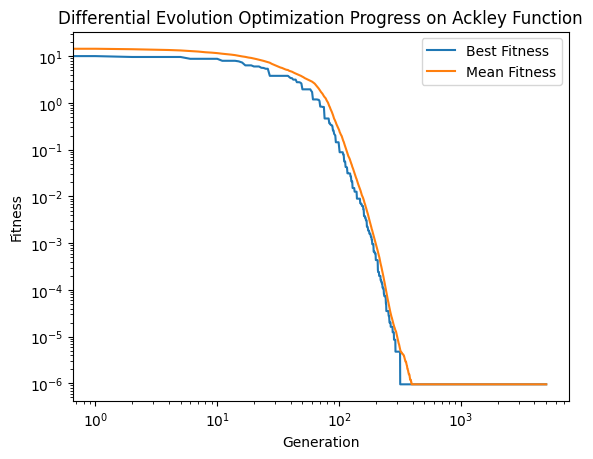

=== SCHWEFEL FUNCTION ===
Best solution found: tensor([420.9847, 420.9774, 420.9831, 420.9943, 420.9874, 420.9843, 420.9575,
        420.9612, 420.9574, 420.9632], device='cuda:0')
Best solution fitness: tensor(0., device='cuda:0')



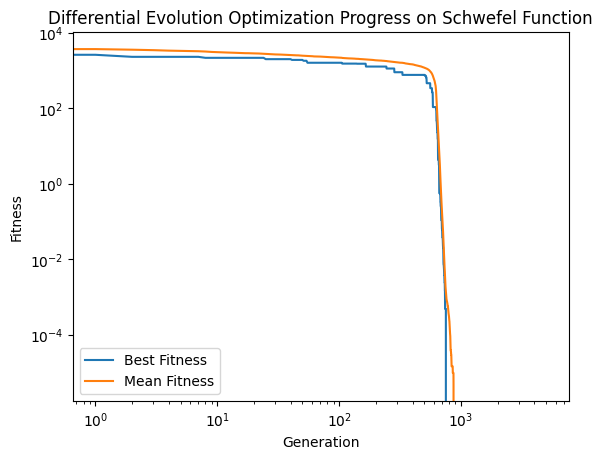

=== GRIEWANK FUNCTION ===
Best solution found: tensor([-1.8661e-04,  1.5942e-04,  1.5177e-04, -3.1304e-04,  4.4118e-04,
         2.5679e-04, -6.3209e-05,  3.6950e-04,  5.4263e-04,  6.9008e-04],
       device='cuda:0')
Best solution fitness: tensor(0., device='cuda:0')



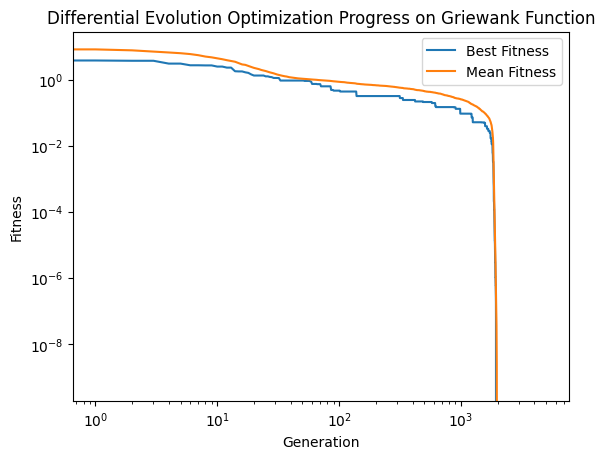

=== LEVY FUNCTION ===
Best solution found: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0')
Best solution fitness: tensor(7.6427e-15, device='cuda:0')



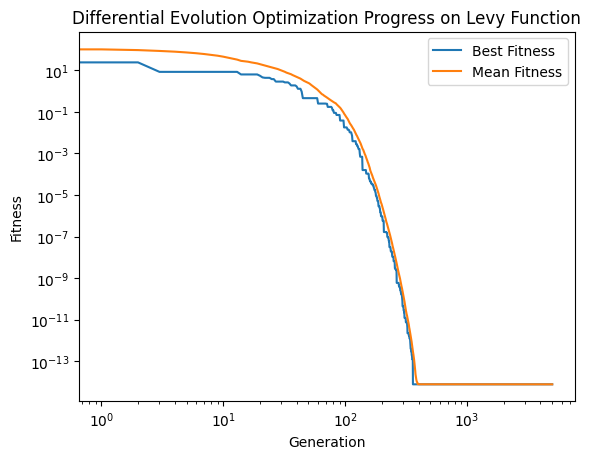

In [8]:
import matplotlib.pyplot as plt


for name, obj in objective_functions.items():
    solution = obj["solution"]
    best_solution, best_fitness, fitness_history = solution["best_solution"], solution["best_fitness"], solution["fitness_history"]
    best_fitness_history = fitness_history["best"]
    mean_fitness_history = fitness_history["mean"]

    print(f"=== {name.upper()} FUNCTION ===")
    print("Best solution found:", best_solution)
    print("Best solution fitness:", best_fitness)
    print()

    plt.plot(best_fitness_history, label="Best Fitness")
    plt.plot(mean_fitness_history, label="Mean Fitness")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.yscale("log")
    plt.xscale("log")
    plt.title(f"Differential Evolution Optimization Progress on {name.capitalize()} Function")
    plt.legend()
    plt.show()

# Very good!